# Análise Facial

Aplicações voltadas a segmentação de imagens por faces, modelos de classificação de faces e modelos de classificação por expressões faciais obtidas por meio de marcos faciais.

## 0. Importação de bibliotecas

In [77]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import shutil

from os import listdir
from os.path import isfile, join

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Exibição na mesma tela do Jupyter
%matplotlib inline

import dlib

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

## 1. Segmentação de imagem por faces

Antes de construirmos um classificador de faces que seja capaz de identificar uma pessoa de outra, precisamos extrair as faces de imagens, seja para compor uma base de treinamento ou para executar uma inferência.

Este tipo de segmentação pode ser realizado por um classificador de face de _Cascata de Harr_. Este tipo de classificador funciona muito bem para identificar objetos, faces, pessoas, animais etc. para segmentar a imagem principal antes de trabalharmos.

Vamos tomar como exemplo a seguinte imagem.

In [10]:
imagem = cv2.imread('imagens/people.jpeg')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

Text(0.5,1,'Pessoas em uma fila')

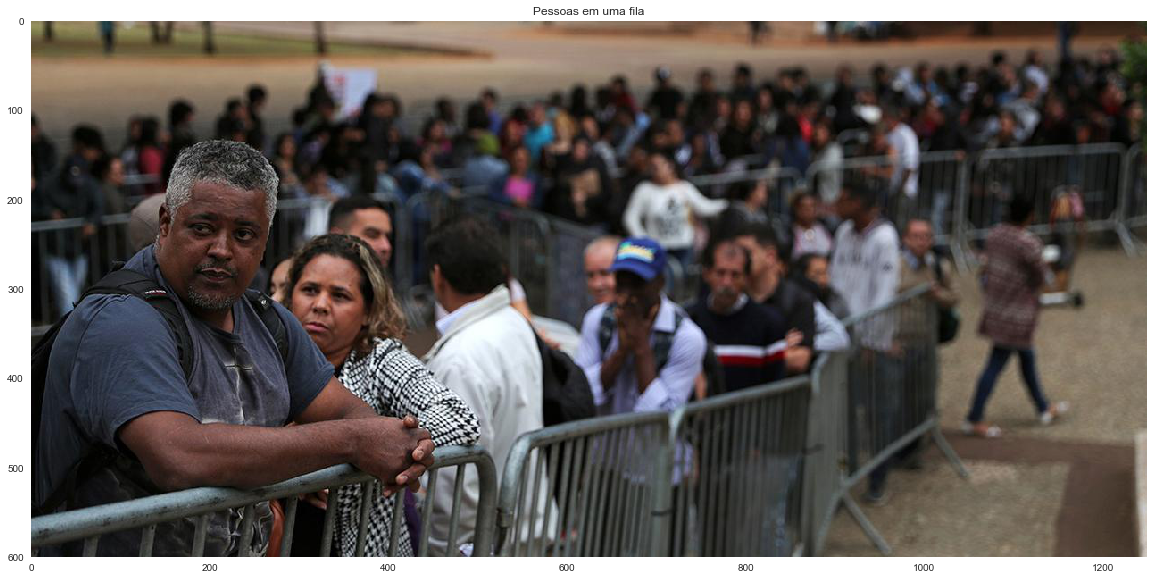

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Pessoas em uma fila")

Para encontrarmos os rotos nesta imagem, vamos antes convertê-la para escala de cinza, pois os classificadores em cascata de Harr trabalham desta forma, ou seja, as informações de cores não são utilizadas.

In [12]:
imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)

Vamos carregar o classificador e aplicar na imagem.
Os parâmetros *1.3* se refere a escala, ou seja, identificações de até 130% do modelo base, para lidar com diferentes dimensões de faces. O outro parâmetro é a quantidade de vizinhos de um determinado agrupamento (_cluster_), indicando um parâmetro de sensibilidade.

In [26]:
classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
faces = classificador_face.detectMultiScale(imagem_gray, 1.3, 5)
print("Faces encontradas: " + str(len(faces)))

Faces encontradas: 3


In [16]:
imagem_anotada = imagem.copy()
for (x,y,w,h) in faces:
    cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

Text(0.5,1,'Pessoas em uma fila')

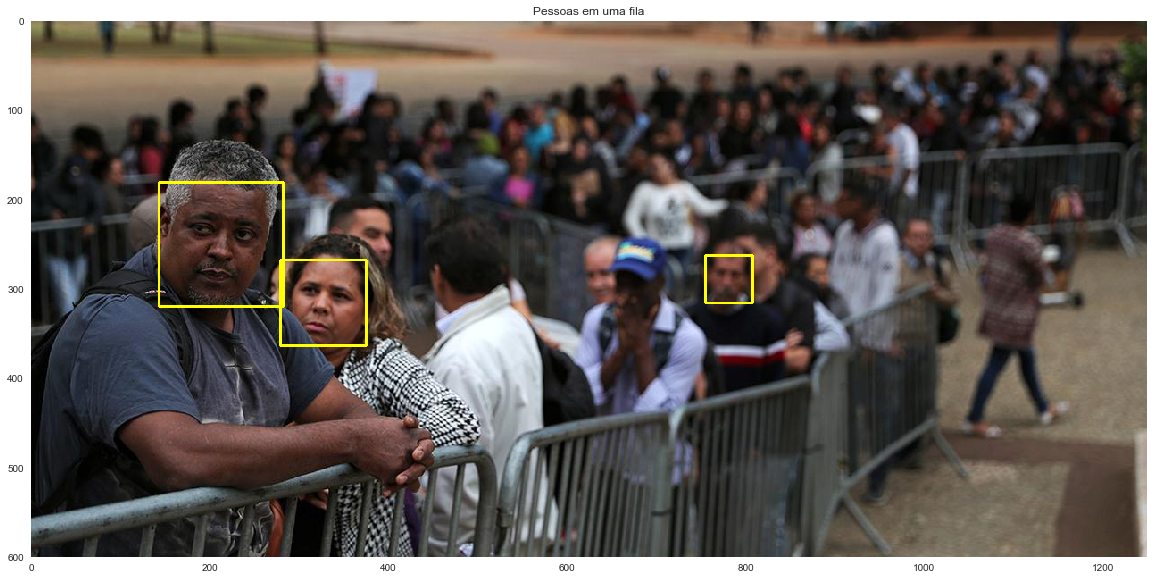

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas em uma fila")

As imagens encontradas podem ser segmentadas da imagem principal, para, por exemplo, ser realizado alguma verificação de identifidade, expressão ou apenas um registro da presença das pessoas.

In [27]:
face_image = 0
for (x,y,w,h) in faces:
    face_image += 1
    roi = imagem[y:y+h, x:x+w]
    cv2.imwrite("face_" + str(face_image)+ ".png", roi)

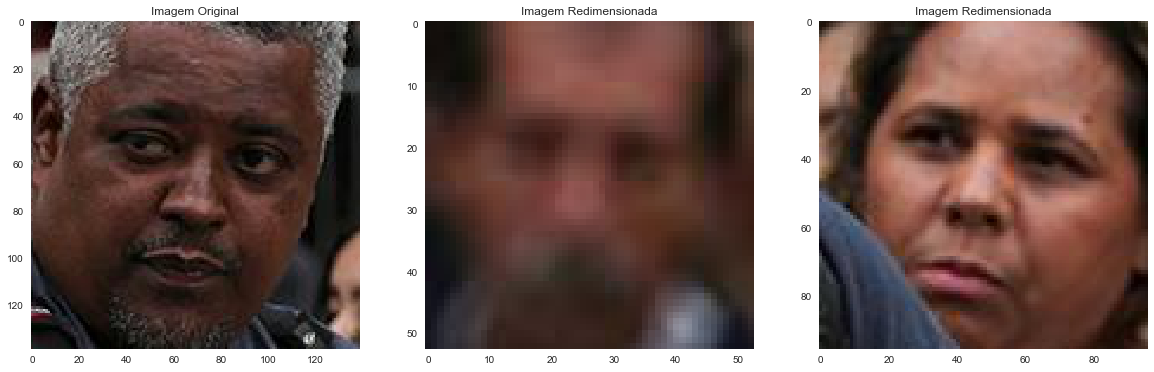

In [30]:
imagem_roi_1 = cv2.imread('face_1.png')
imagem_roi_2 = cv2.imread('face_2.png')
imagem_roi_3 = cv2.imread('face_3.png')

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title("ROI #1")
plt.imshow(imagem_roi_1)
plt.subplot(132)
plt.title("ROI #1)
plt.imshow(imagem_roi_2)
plt.subplot(133)
plt.title("ROI #1")
plt.imshow(imagem_roi_3)
plt.show()

## 2. Classificação de faces

O OpenCV possui 3 classificadores de faces com diferentes algoritmos.

O **Eingenfaces** utiliza um plano _facial_ que, por meio de aplicação de PCA (_Principal Component Analysis_) cria regiões com características específicas de um rosto. Por exemplo, image um plano que, a partir de uma face média, o ponto de origem, você possa navegar por componentes de cabelo comprido, bigode, etc. a medida que se aproxima desta região onde há faces que compartilham essas características.

Por outro lado, o algoritmo **FisherFaces** optou por utilizar outra forma de redução de dimensionalidade, o LDA (_Linear Discriminant Analysis_). A estratégia deste algoritmo é maximizar a diferença entre classes, ou seja, as faces, sendo mais robusto em classificar imagens mesmo com variações em expressões e até mesmo iluminação.

Finalmente, o algoritmo **LBPH ou Local Binary Pattern Histogram** parte para uma forma diferente da anteriores para classificar faces. Por meio de uma janela convulacional (uma janela móvel com um _kernel_ ou tamanho pré-definido), é extraído o histograma de cada quadrante da imagem, para compor, posteriormente um vetor de caracaterísticas fortemente baseado em texturas.

O uso e escolha de cada algoritmo pode variar de acordo com cada problema. Condições mais robustas onde há mais variação seja de expressões ou iluminação, os algoritmos _Fisherfaces_  e _LBPH_ são os mais indicados. Aplicações com imagens padronizadas, como utilizadas em documentos ou que não sofram grandes variações em expressões ou mesmo iluminação, o algoritmo _Eingenfaces_ é indicado.

### 2.1 Conjunto de dados

Para este experimento, vamos utilizar o conjunto de dados da _Georgia Tech_. Os dados podem ser obtidos por meio deste [link](http://www.anefian.com/research/face_reco.htm).

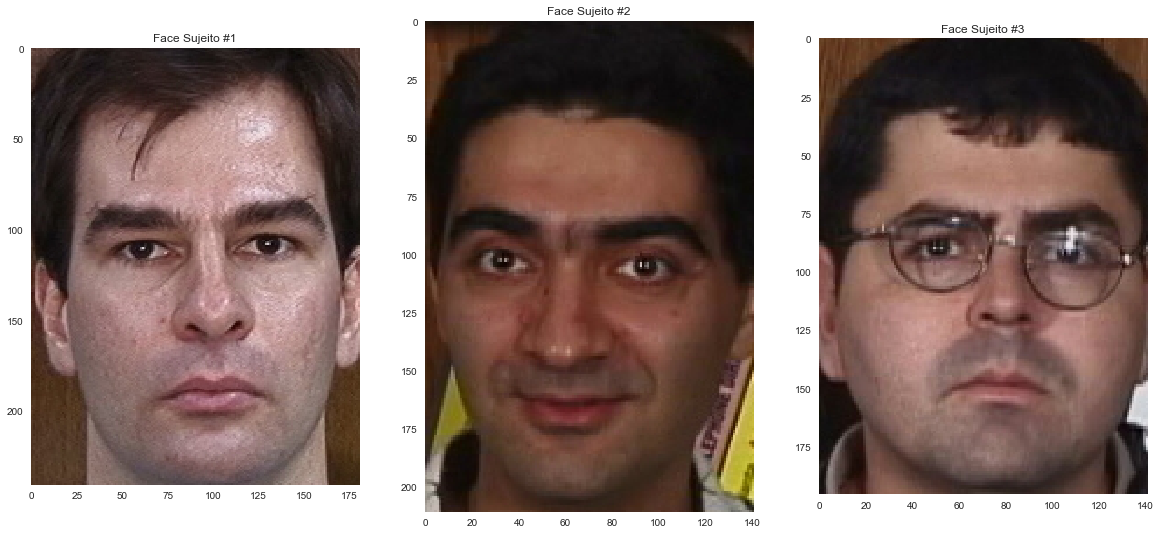

In [37]:
imagem_face_1 = cv2.imread('imagens/cropped_faces/s01_01.jpg')
imagem_face_1 = cv2.cvtColor(imagem_face_1, cv2.COLOR_BGR2RGB)
imagem_face_2 = cv2.imread('imagens/cropped_faces/s02_01.jpg')
imagem_face_2 = cv2.cvtColor(imagem_face_2, cv2.COLOR_BGR2RGB)
imagem_face_3 = cv2.imread('imagens/cropped_faces/s03_01.jpg')
imagem_face_3= cv2.cvtColor(imagem_face_3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title("Face Sujeito #1")
plt.imshow(imagem_face_1)
plt.subplot(132)
plt.title("Face Sujeito #2")
plt.imshow(imagem_face_2)
plt.subplot(133)
plt.title("Face Sujeito #3")
plt.imshow(imagem_face_3)
plt.show()

Neste conjunto de dados, o nome do arquivo seguido por "s" (exemplo "s03_01.jpg"), é o número do sujeito, ou seja, a pessoa associada. Há 15 exemplos para cada sujeito.

Podemos notar também que as imagens já estão recortadas, portanto não será preciso segmentá-las. No entanto, elas possuem tamanhos diferentes.

In [38]:
print(imagem_face_1.shape)
print(imagem_face_2.shape)
print(imagem_face_3.shape)

(241, 181, 3)
(211, 141, 3)
(196, 141, 3)


A pasta _cropped_faces_ possui os arquivos originais.
Iremos precisar separar os dados em treino e teste, para validar o nosso modelo. Como a quantidade de imagens é pequena por sujeito, vamos considerar 10 (66%) imagens para treino e 5 para teste (33%).

In [46]:
faces_caminho = 'imagens/cropped_faces/'
lista_arquivos_faces = [f for f in listdir(faces_caminho) if isfile(join(faces_caminho, f))]
lista_arquivos_faces[0]

's23_06.jpg'

In [58]:
faces_caminho_train = 'imagens/train/'
faces_caminho_test = 'imagens/test/'

if not os.path.exists(faces_caminho_train):
    os.makedirs(faces_caminho_train)
if not os.path.exists(faces_caminho_test):
    os.makedirs(faces_caminho_test)

for arquivo in lista_arquivos_faces:
    subject = arquivo[1:3]
    count = arquivo[4:6]
    
    if int(count)<=10:
        shutil.copyfile(faces_caminho + arquivo, faces_caminho_train + arquivo)
    else:
        shutil.copyfile(faces_caminho + arquivo, faces_caminho_test + arquivo)

Nesta próxima etapa, vamos reunir as imagens de treinamento para realizar o pré-processamento. Esta etapa se encarregará das seguintes transformações:

* conversão em escala de cinza da imagem
* redimensionamento para um tamanhao padrão de 250 x 200 (escala que minimiza eventuais distorções)

In [73]:
lista_faces_train = [f for f in listdir(faces_caminho_train) if isfile(join(faces_caminho_train, f))]
lista_faces_train[0]

lista_faces_test = [f for f in listdir(faces_caminho_test) if isfile(join(faces_caminho_test, f))]
lista_faces_test[0]

's23_12.jpg'

In [88]:
dados_treinamento, labels = [], []

for i, arquivo in enumerate(lista_faces_train):
    imagem_caminho = faces_caminho_train + arquivo
    imagem = cv2.imread(imagem_caminho, cv2.IMREAD_GRAYSCALE)
    imagem = cv2.resize(imagem, (200, 200),interpolation=cv2.INTER_LANCZOS4)
    dados_treinamento.append(imagem)
    subject = arquivo[1:3]
    labels.append(int(subject))
labels = np.asarray(labels, dtype=np.int32)

In [101]:
model = cv2.face.LBPHFaceRecognizer_create()
model.train(dados_treinamento, labels)

In [90]:
dados_test, labels_test = [], []
y_test = []

for i, arquivo in enumerate(lista_faces_test):
    imagem_caminho = faces_caminho_test + arquivo
    imagem = cv2.imread(imagem_caminho, cv2.IMREAD_GRAYSCALE)
    imagem = cv2.resize(imagem, (200, 200),interpolation=cv2.INTER_LANCZOS4)
    dados_test.append(imagem)
    subject = arquivo[1:3]
    labels_test.append(int(subject))
    y_test.append(int(subject))
    
labels_test = np.asarray(labels_test, dtype=np.int32)

In [103]:
y_pred = []

for item in dados_test:
    y_pred.append(model.predict(item)[0])

In [104]:
print("Accuracy:" + str(accuracy_score(y_test, y_pred)))

Accuracy:0.792


In [105]:
model = cv2.face.FisherFaceRecognizer_create()
model.train(dados_treinamento, labels)

In [106]:
y_pred = []

for item in dados_test:
    y_pred.append(model.predict(item)[0])

In [107]:
print("Accuracy:" + str(accuracy_score(y_test, y_pred)))

Accuracy:0.52


In [97]:
model = cv2.face.EigenFaceRecognizer_create()
model.train(dados_treinamento, labels)

In [98]:
y_pred = []

for item in dados_test:
    y_pred.append(model.predict(item)[0])

In [100]:
print("Accuracy:" + str(accuracy_score(y_test, y_pred)))

Accuracy:0.724
